In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, AUC
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image, ImageDraw
import pydicom
import numpy as np
import pandas as pd
import os
import glob
import cv2

import matplotlib.pyplot as plt
import seaborn as sns # Para o heatmap
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

print("Configuração inicial e imports concluídos.")

Configuração inicial e imports concluídos.


## Preparação dos Dados

In [ ]:
"""
- PREPARA OS DADOS GERANDO UM DATAFRAME:

Prepara dados, criando um único DataFrame com os rótulos,
caminhos de imagem e informações dos bounding boxes.
"""

# Configuração de caminhos
image_base_dir = 'rsna-pneumonia-detection-challenge/stage_2_train_images'
annotation_file_path = 'rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
detailed_info_path = 'rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'

# Carregar Dados
annotations_df = pd.read_csv(annotation_file_path)
detailed_info_df = pd.read_csv(detailed_info_path)

# Mapear PatientID para Caminho do Arquivo DCM
dcm_files = glob.glob(os.path.join(image_base_dir, '*.dcm'))
patient_id_to_path = {os.path.splitext(os.path.basename(dcm_path))[0]: dcm_path for dcm_path in dcm_files}

# Criar o dicionário PatientID para Anotações Completas
patient_id_to_annotations = {}
for patient_id, group in annotations_df.groupby('patientId'):
    patient_id_to_annotations[patient_id] = group.to_dict('records')

# Criar o dicionário PatientID para Informação Detalhada da Classe
patient_id_to_detailed_class = detailed_info_df.set_index('patientId')['class'].to_dict()

# Criar o DataFrame images_with_boxes_df
data_for_df = []
available_patient_ids = list(patient_id_to_path.keys())

for patient_id in available_patient_ids:
    patient_annotations = annotations_df[annotations_df['patientId'] == patient_id].to_dict('records')
    if not patient_annotations:
        detailed_class = patient_id_to_detailed_class.get(patient_id, 'Unknown')
        data_for_df.append({
            'patientId': patient_id,
            'image_path': patient_id_to_path.get(patient_id),
            'Target': 0 if 'Normal' in detailed_class else 1,
            'detailed_class': detailed_class,
            'boxes': [],
            'num_boxes': 0
        })
        continue

    image_target = patient_annotations[0]['Target']
    image_path = patient_id_to_path.get(patient_id)

    boxes = []
    if image_target == 1:
        for ann in patient_annotations:
            if not pd.isna(ann['x']) and ann['Target'] == 1:
                x, y, w, h = ann['x'], ann['y'], ann['width'], ann['height']
                boxes.append([x, y, x + w, y + h])

    detailed_class = patient_id_to_detailed_class.get(patient_id, 'Unknown')

    if image_path:
        data_for_df.append({
            'patientId': patient_id,
            'image_path': image_path,
            'Target': image_target,
            'detailed_class': detailed_class,
            'boxes': boxes,
            'num_boxes': len(boxes)
        })

images_with_boxes_df = pd.DataFrame(data_for_df)

print("Dados carregados e DataFrame de imagens criado.")
print(f"Número de imagens no DataFrame: {len(images_with_boxes_df)}")
print(f"Distribuição da classe Target:\n{images_with_boxes_df['Target'].value_counts()}")

Dados carregados e DataFrame de imagens criado.
Número de imagens no DataFrame: 26684
Distribuição da classe Target:
Target
0    20672
1     6012
Name: count, dtype: int64


In [ ]:
"""
- SEPARAÇÃO EM TREINO, VALIDAÇÃO E TESTE (70% / 15% / 15%):

Define um pipeline de pré-processamento de imagens para o treinamento.
Inclui funções para carregar, pré-processar e transformar imagens, 
além de criar e configurar datasets para treino, validação e teste.
"""

# Função para carregar e pré-processar uma única imagem DICOM
def load_and_preprocess_image_tf(image_path, label):
    # Carrega imagem DICOM e pré-processa.
    image_path_str = image_path.numpy().decode('utf-8')
    dcm_data = pydicom.dcmread(image_path_str)
    image = dcm_data.pixel_array
    image = image.astype(np.float32)
    min_val = image.min()
    max_val = image.max()
    if max_val - min_val > 0:
        image = (image - min_val) / (max_val - min_val) * 255.0
    else:
        image = np.zeros_like(image, dtype=np.float32)
    image = np.stack([image] * 3, axis=-1)
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
    return image_tensor, label_tensor

# Função Wrapper para tf.py_function
def tf_load_and_preprocess(image_path, label):
    # Wrapper para chamar load_and_preprocess_image_tf com tf.py_function.
    image, label = tf.py_function(
        load_and_preprocess_image_tf,
        [image_path, label],
        [tf.float32, tf.float32]
    )
    image.set_shape((256, 256, 3))
    label.set_shape(())
    return image, label

# Definição das Transformações de Imagem com TensorFlow Ops
def apply_transformations(image, label):
    # Aplica redimensionamento e normalização usando TensorFlow Ops.
    image = tf.image.resize(image, (256, 256))
    image = image / 255.0
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    image = (image - mean) / std
    return image, label

# Divisão dos Dados
train_df, temp_df = train_test_split(images_with_boxes_df, test_size=0.3, random_state=42, stratify=images_with_boxes_df['Target'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Target'])

# Converter labels para float32 ANTES de criar o Dataset
train_paths = train_df['image_path'].values
train_labels = train_df['Target'].values.astype(np.float32)

val_paths = val_df['image_path'].values
val_labels = val_df['Target'].values.astype(np.float32)

test_paths = test_df['image_path'].values
test_labels = test_df['Target'].values.astype(np.float32)

# Criação dos TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Construir o Pipeline de Dados
batch_size = 32
buffer_size = tf.data.AUTOTUNE

# Pipeline para Treino
train_dataset = train_dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
train_dataset = train_dataset.map(apply_transformations, num_parallel_calls=buffer_size)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)

# Pipeline para Validação e Teste
val_dataset = val_dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
val_dataset = val_dataset.map(apply_transformations, num_parallel_calls=buffer_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)

test_dataset = test_dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
test_dataset = test_dataset.map(apply_transformations, num_parallel_calls=buffer_size)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)

print("Pipeline de dados do TensorFlow criado com correção de dtype.")

Pipeline de dados do TensorFlow criado com correção de dtype.


In [ ]:
print(f"Tamanho do conjunto de treino: {len(train_df)}")
print(f"Tamanho do conjunto de validação: {len(val_df)}")
print(f"Tamanho do conjunto de teste: {len(test_df)}")

Tamanho do conjunto de treino: 18678
Tamanho do conjunto de validação: 4003
Tamanho do conjunto de teste: 4003


In [ ]:
"""
- BALANCEAMENTO DE CLASSES E RECONSTRÓI PIPELINES DE DADOS:

Balanceamento das classes dos DataFrames de treino, validação e teste,
especialmente nas colunas 'Target' e 'detailed_class', para garantir uma distribuição
mais equitativa dos dados. Após o balanceamento, os pipelines de dados do TensorFlow
são recriados utilizando os DataFrames balanceados.
"""

def balance_dataframe(df_to_balance, target_class_counts=None, random_seed=42):
    # Balanceia um DataFrame com base nas classes 'Target' e 'detailed_class'.
    np.random.seed(random_seed)

    df_neg = df_to_balance[df_to_balance['Target'] == 0].copy()
    df_pos = df_to_balance[df_to_balance['Target'] == 1].copy()

    num_pos_samples_target = len(df_pos) if target_class_counts is None else target_class_counts.get(1, len(df_pos))

    if len(df_pos) < num_pos_samples_target:
        print(f"Warning: Not enough positive samples to reach target {num_pos_samples_target}. Oversampling positive samples with replacement.")
        df_pos_balanced = df_pos.sample(n=num_pos_samples_target, replace=True, random_state=random_seed)
    else:
        df_pos_balanced = df_pos.sample(n=num_pos_samples_target, random_state=random_seed)

    df_normal = df_neg[df_neg['detailed_class'] == 'Normal'].copy()
    df_not_normal = df_neg[df_neg['detailed_class'] == 'Not normal'].copy()

    num_neg_samples_target = num_pos_samples_target
    num_neg_samples_per_detailed_class = num_neg_samples_target // 2

    df_normal_sampled = df_normal.sample(n=min(len(df_normal), num_neg_samples_per_detailed_class),
                                         replace=(len(df_normal) < num_neg_samples_per_detailed_class),
                                         random_state=random_seed)
    df_not_normal_sampled = df_not_normal.sample(n=min(len(df_not_normal), num_neg_samples_per_detailed_class),
                                                  replace=(len(df_not_normal) < num_neg_samples_per_detailed_class),
                                                  random_state=random_seed)

    df_neg_balanced = pd.concat([df_normal_sampled, df_not_normal_sampled])

    if len(df_neg_balanced) < num_neg_samples_target:
        df_neg_balanced = df_neg_balanced.sample(n=num_neg_samples_target, replace=True, random_state=random_seed)
    elif len(df_neg_balanced) > num_neg_samples_target:
        df_neg_balanced = df_neg_balanced.sample(n=num_neg_samples_target, random_state=random_seed)

    balanced_df = pd.concat([df_neg_balanced, df_pos_balanced]).sample(frac=1, random_state=random_seed).reset_index(drop=True)

    print(f"\nBalancing complete for a split. Stats for this balanced DataFrame:")
    print(f"  Total samples: {len(balanced_df)}")
    print(f"  Target distribution:\n{balanced_df['Target'].value_counts()}")
    print(f"  Detailed class for Target=0:\n{balanced_df[balanced_df['Target'] == 0]['detailed_class'].value_counts()}")
    print(f"  Num boxes for Target=1:\n{balanced_df[balanced_df['Target'] == 1]['num_boxes'].value_counts()}")

    return balanced_df

print("Applying balancing to Training DataFrame...")
balanced_train_df = balance_dataframe(train_df, random_seed=42)

print("\nApplying balancing to Validation DataFrame...")
balanced_val_df = balance_dataframe(val_df, random_seed=42)

print("\nApplying balancing to Test DataFrame...")
balanced_test_df = balance_dataframe(test_df, random_seed=42)

def create_tf_dataset_pipeline(df, buffer_size, batch_size):
    # Cria e pré-processa um TensorFlow Dataset.
    paths = df['image_path'].values
    labels = df['Target'].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
    dataset = dataset.map(apply_transformations, num_parallel_calls=buffer_size)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=buffer_size)
    return dataset

print("\nRe-creating TensorFlow Datasets with balanced data...")

balanced_train_dataset = create_tf_dataset_pipeline(balanced_train_df, buffer_size, batch_size)
balanced_val_dataset = create_tf_dataset_pipeline(balanced_val_df, buffer_size, batch_size)
balanced_test_dataset = create_tf_dataset_pipeline(balanced_test_df, buffer_size, batch_size)

print("Balanced TensorFlow Datasets (train, val, test) created successfully.")

Applying balancing to Training DataFrame...

Balancing complete for a split. Stats for this balanced DataFrame:
  Total samples: 8416
  Target distribution:
Target
1    4208
0    4208
Name: count, dtype: int64
  Detailed class for Target=0:
detailed_class
Normal    4208
Name: count, dtype: int64
  Num boxes for Target=1:
num_boxes
2    2263
1    1855
3      81
4       9
Name: count, dtype: int64

Applying balancing to Validation DataFrame...

Balancing complete for a split. Stats for this balanced DataFrame:
  Total samples: 1804
  Target distribution:
Target
1    902
0    902
Name: count, dtype: int64
  Detailed class for Target=0:
detailed_class
Normal    902
Name: count, dtype: int64
  Num boxes for Target=1:
num_boxes
2    473
1    408
3     17
4      4
Name: count, dtype: int64

Applying balancing to Test DataFrame...

Balancing complete for a split. Stats for this balanced DataFrame:
  Total samples: 1804
  Target distribution:
Target
1    902
0    902
Name: count, dtype: int64
 

## Modelo Resnet50 sem Balanceamento dos Datasets: 78% acc

In [ ]:
"""
- DEFINIÇÃO DO MODELO RESNET50 PARA CLASSIFICAÇÃO BINÁRIA
"""

# Definição do Modelo Keras
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congela as camadas do modelo base
base_model.trainable = False

# Cria o modelo sequencial no topo do modelo base
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

print("Modelo Keras definido.")
model.summary()

Modelo Keras definido.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
"""
- COMPILAÇÃO DO MODELO
"""

# Compilação do Modelo
optimizer = Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics = [BinaryAccuracy(name='accuracy'), AUC(name='auc')]

# Compila o modelo
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

print("Modelo compilado.")

Modelo compilado.


In [ ]:
"""
- TREINAMENTO DO MODELO:

Define ModelCheckpoint para salvar o melhor modelo durante o treinamento e, em seguida,
inicia o treinamento.
"""

# Callbacks de Treinamento
checkpoint_callback = ModelCheckpoint(
    filepath='best_pneumonia_classifier_tf.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [checkpoint_callback]

# Treinamento do Modelo
epochs = 5

print("Iniciando treinamento...")

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks_list
)

print("Treinamento concluído.")

Iniciando treinamento...
Epoch 1/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7553 - auc: 0.6876 - loss: 0.5058
Epoch 1: val_auc improved from -inf to 0.76335, saving model to best_pneumonia_classifier_tf.keras
584/584 ━━━━━━━━━━━━━━━━━━━━ 1983s 3s/step - accuracy: 0.7553 - auc: 0.6876 - loss: 0.5058 - val_accuracy: 0.7799 - val_auc: 0.7634 - val_loss: 0.4573
Epoch 2/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7857 - auc: 0.7656 - loss: 0.4569
Epoch 2: val_auc improved from 0.76335 to 0.77443, saving model to best_pneumonia_classifier_tf.keras
584/584 ━━━━━━━━━━━━━━━━━━━━ 1889s 3s/step - accuracy: 0.7857 - auc: 0.7656 - loss: 0.4569 - val_accuracy: 0.7899 - val_auc: 0.7744 - val_loss: 0.4502
Epoch 3/5
584/584 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7939 - auc: 0.7804 - loss: 0.4455
Epoch 3: val_auc improved from 0.77443 to 0.77918, saving model to best_pneumonia_classifier_tf.keras
584/584 ━━━━━━━━━━━━━━━━━━━━ 1876s 3s/step - accuracy: 0.7939 - auc: 0.7804 

In [ ]:
"""
- AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE:
"""
# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_classifier_tf.keras'

# Carregar o modelo salvo
try:
    loaded_model = tf.keras.models.load_model(saved_model_path)
    print(f"Modelo carregado com sucesso de: {saved_model_path}")

    if 'test_dataset' in locals():
        print("Avaliando o modelo carregado no conjunto de teste...")
        loaded_model.evaluate(test_dataset)
    else:
        print("test_dataset não encontrado. Não é possível avaliar o modelo carregado.")

except Exception as e:
    print(f"Erro ao carregar o modelo de {saved_model_path}: {e}")
    print("Certifique-se de que o caminho está correto e o arquivo existe.")

Modelo carregado com sucesso de: best_pneumonia_classifier_tf.keras
Avaliando o modelo carregado no conjunto de teste...
126/126 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.7877 - auc: 0.7935 - loss: 0.4411


Gerando mapas de calor das matrizes de confusão...

--- Matriz de Confusão (Target Binário Real vs. Previsto Binário) ---
      0    1
0  3018   83
1   738  164


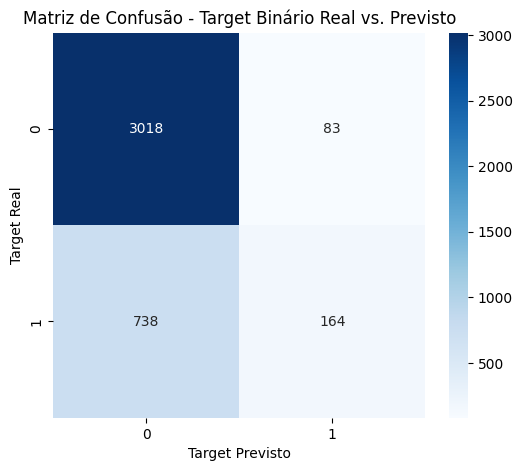

In [ ]:
"""
- MATRIZES DE CONFUSÃO:

Realiza previsões no conjunto de teste e então calcula e exibe
mapas de calor das matrizes de confusão.
"""

# Verifica e carrega o modelo
if 'model' not in locals() and 'loaded_model' not in locals():
    print("Erro: Modelo treinado ou carregado não encontrado.")
elif 'loaded_model' in locals():
    model = loaded_model
    print("Usando modelo carregado para avaliação.")
else:
    print("Usando modelo da sessão atual para avaliação.")

# Calcula previsões
if 'test_df' not in locals() or 'test_dataset' not in locals() or model is None:
    print("Erro: test_df, test_dataset ou modelo não encontrados. Rode as células anteriores.")
else:
    print("Calculando previsões para o conjunto de teste...")
    y_pred_probs = model.predict(test_dataset)
    y_pred_binary = np.round(y_pred_probs).flatten()
    y_true_binary = test_df['Target'].values.astype(np.float32)

# Gera mapas de calor das matrizes de confusão
if 'y_true_binary' not in locals() or 'y_true_detailed' not in locals() or 'y_pred_binary' not in locals() or 'true_detailed_classes' not in locals():
    print("Erro: Variáveis de labels e previsões (y_true_binary, y_true_detailed, y_pred_binary, true_detailed_classes) não encontradas. Rode as células anteriores para calculá-las.")
else:
    print("Gerando mapas de calor das matrizes de confusão...")

    # Mapa de Calor 1: Target Binário Real vs. Previsto Binário
    print("\n--- Matriz de Confusão (Target Binário Real vs. Previsto Binário) ---")
    binary_class_labels = [0, 1]
    cm_binary = confusion_matrix(
        y_true_binary,
        y_pred_binary,
        labels=binary_class_labels
    )
    cm_binary_df = pd.DataFrame(cm_binary, index=binary_class_labels, columns=binary_class_labels)

    print(cm_binary_df)

    # Visualizar como Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_binary_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão - Target Binário Real vs. Previsto')
    plt.xlabel('Target Previsto')
    plt.ylabel('Target Real')
    plt.show()


--- Distribuição e Proporção das Classes Detalhadas no Conjunto de Treinamento ---

Contagem no Conjunto de Treinamento:
detailed_class
No Lung Opacity / Not Normal    8274
Normal                          6196
Lung Opacity                    4208
Name: count, dtype: int64

Proporção no Conjunto de Treinamento:
detailed_class
No Lung Opacity / Not Normal    0.442981
Normal                          0.331727
Lung Opacity                    0.225292
Name: proportion, dtype: float64


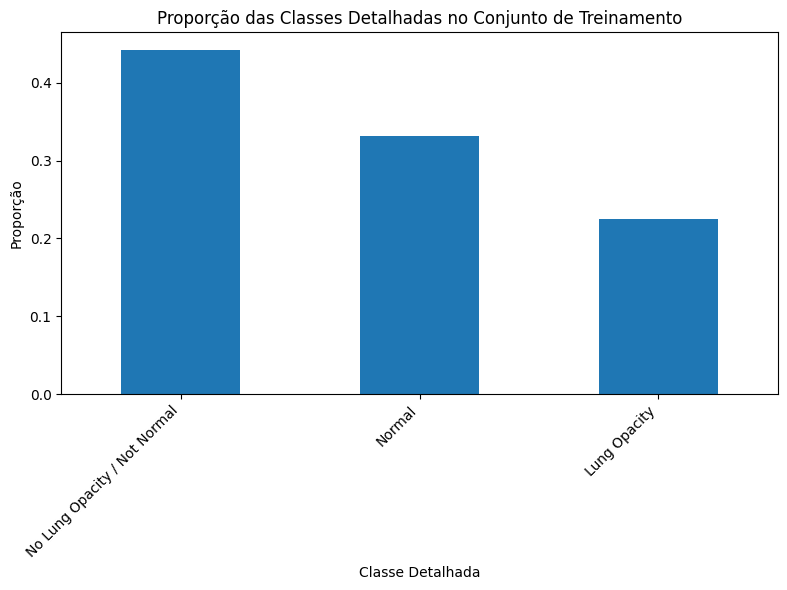

In [ ]:
"""
- ANÁLISE DE DISTRIBUIÇÃO DAS CLASSES DETALHADAS NO TREINO
"""

if 'train_df' not in locals():
    print("Erro: train_df não encontrado. Rode a Célula 3 primeiro (Divisão dos Dados).")
else:
    print("\n--- Distribuição e Proporção das Classes Detalhadas no Conjunto de Treinamento ---")

    train_detailed_class_counts = train_df['detailed_class'].value_counts()
    print("\nContagem no Conjunto de Treinamento:")
    print(train_detailed_class_counts)

    train_detailed_class_proportions = train_df['detailed_class'].value_counts(normalize=True)
    print("\nProporção no Conjunto de Treinamento:")
    print(train_detailed_class_proportions)

    plt.figure(figsize=(8, 6))
    train_detailed_class_proportions.plot(kind='bar')
    plt.title('Proporção das Classes Detalhadas no Conjunto de Treinamento')
    plt.xlabel('Classe Detalhada')
    plt.ylabel('Proporção')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


--- Distribuição e Proporção do Target Binário no Conjunto de Treinamento ---

Contagem do Target no Conjunto de Treinamento:
Target
0    14470
1     4208
Name: count, dtype: int64

Proporção do Target no Conjunto de Treinamento:
Target
0    0.774708
1    0.225292
Name: proportion, dtype: float64


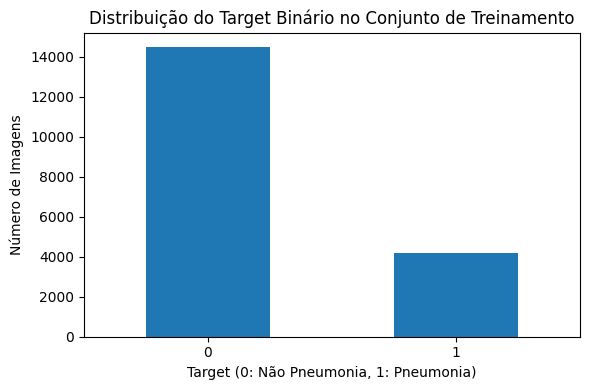

In [ ]:
"""
- ANÁLISE DE DISTRIBUIÇÃO DO TARGET BINÁRIO NO TREINO
"""

if 'train_df' not in locals():
    print("Erro: train_df não encontrado. Rode a Célula 3 (Divisão dos Dados) primeiro.")
else:
    print("\n--- Distribuição e Proporção do Target Binário no Conjunto de Treinamento ---")

    train_target_counts = train_df['Target'].value_counts()
    print("\nContagem do Target no Conjunto de Treinamento:")
    print(train_target_counts)

    train_target_proportions = train_df['Target'].value_counts(normalize=True)
    print("\nProporção do Target no Conjunto de Treinamento:")
    print(train_target_proportions)

    plt.figure(figsize=(6, 4))
    train_target_counts.plot(kind='bar')
    plt.title('Distribuição do Target Binário no Conjunto de Treinamento')
    plt.xlabel('Target (0: Não Pneumonia, 1: Pneumonia)')
    plt.ylabel('Número de Imagens')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Modelo Resnet50 com Balanceamento dos Datasets: 

In [ ]:
"""
- DEFINIÇÃO DO MODELO RESNET50 PARA CLASSIFICAÇÃO BINÁRIA
"""

# Definição do Modelo Keras
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congela as camadas do modelo base
base_model.trainable = False

# Cria o modelo sequencial no topo do modelo base
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

print("Modelo Keras definido.")
model.summary()

Modelo Keras definido.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
"""
- COMPILAÇÃO DO MODELO
"""

# Compilação do Modelo
optimizer = Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics = [BinaryAccuracy(name='accuracy'), AUC(name='auc')]

# Compila o modelo
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

print("Modelo compilado.")

Modelo compilado.


In [ ]:
"""
- TREINAMENTO DO MODELO:

Define ModelCheckpoint para salvar o melhor modelo durante o treinamento e, em seguida,
inicia o treinamento.
"""

# Callbacks de Treinamento
checkpoint_callback = ModelCheckpoint(
    filepath='best_pneumonia_resnet50_balanced.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [checkpoint_callback]

# Treinamento do Modelo
epochs = 5

print("Iniciando treinamento...")

# Passa os datasets balanceados
history = model.fit(
    balanced_train_dataset,
    epochs=epochs,
    validation_data=balanced_val_dataset,
    callbacks=callbacks_list
)

print("Treinamento concluído.")

Iniciando treinamento...
Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6811 - auc: 0.7409 - loss: 0.5976
Epoch 1: val_auc improved from -inf to 0.82919, saving model to best_pneumonia_resnet50_balanced.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 1304s 5s/step - accuracy: 0.6814 - auc: 0.7411 - loss: 0.5974 - val_accuracy: 0.7456 - val_auc: 0.8292 - val_loss: 0.5188
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7748 - auc: 0.8434 - loss: 0.4951
Epoch 2: val_auc improved from 0.82919 to 0.84183, saving model to best_pneumonia_resnet50_balanced.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 915s 3s/step - accuracy: 0.7749 - auc: 0.8435 - loss: 0.4951 - val_accuracy: 0.7578 - val_auc: 0.8418 - val_loss: 0.4988
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7771 - auc: 0.8584 - loss: 0.4746
Epoch 3: val_auc improved from 0.84183 to 0.84949, saving model to best_pneumonia_resnet50_balanced.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 833s 3s/step - accuracy: 0.7772 - au

In [ ]:
"""
- AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE
"""

# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_resnet50_balanced.keras'

# Carregar o modelo salvo
try:
    loaded_model = tf.keras.models.load_model(saved_model_path)
    print(f"Modelo carregado com sucesso de: {saved_model_path}")

    if 'test_dataset' in locals():
        print("Avaliando o modelo carregado no conjunto de teste...")
        loaded_model.evaluate(balanced_test_dataset)
    else:
        print("test_dataset não encontrado. Não é possível avaliar o modelo carregado.")

except Exception as e:
    print(f"Erro ao carregar o modelo de {saved_model_path}: {e}")
    print("Certifique-se de que o caminho está correto e o arquivo existe.")

Modelo carregado com sucesso de: best_pneumonia_resnet50_balanced.keras
Avaliando o modelo carregado no conjunto de teste...
57/57 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8326 - auc: 0.9138 - loss: 0.3933


Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...
57/57 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step


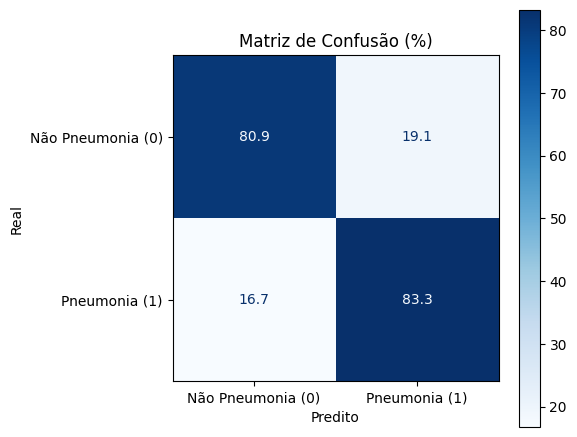


Análise da Matriz de Confusão em %:
Cada célula mostra a **porcentagem** de amostras da classe real (linha) que foi predita como a classe correspondente (coluna).
A soma das porcentagens em cada linha (horizontalmente) deve ser **100%**.


In [ ]:
"""
- MATRIZES DE CONFUSÃO:

Realiza previsões no conjunto de teste e então calcula e exibe
mapas de calor das matrizes de confusão.
"""

# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_resnet50_balanced.keras'

# Carregar o modelo salvo
model = tf.keras.models.load_model(saved_model_path)
print(f"Modelo carregado com sucesso de: {saved_model_path}")

print("Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...")

# Re-cria o dataset de teste SEM shuffle para garantir a ordem das previsões
test_images_paths = balanced_test_df['image_path'].values
test_true_binary_labels = balanced_test_df['Target'].values.astype(np.float32)
test_true_detailed_labels = balanced_test_df['detailed_class'].values

temp_test_dataset_for_prediction = tf.data.Dataset.from_tensor_slices((test_images_paths, test_true_binary_labels))
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(apply_transformations, num_parallel_calls=buffer_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.batch(batch_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.prefetch(buffer_size=buffer_size)

# Obter as probabilidades de predição do modelo
y_pred_probs = model.predict(temp_test_dataset_for_prediction).flatten()

# Converter probabilidades para classes binárias (0 ou 1)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Prepara Labels para a Matriz de Confusão
true_labels_for_cm = test_true_detailed_labels
predicted_labels_for_cm = np.array(['Não Pneumonia (0)' if p == 0 else 'Pneumonia (1)' for p in y_pred_binary])

true_class_order = ['Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity']
predicted_class_order = ['Não Pneumonia (0)', 'Pneumonia (1)']

# Gerar Matriz de Confusão
cm_bin_abs = confusion_matrix(test_true_binary_labels, y_pred_binary, labels=[0,1])

# Normalizar a matriz de confusão por linha
cm_bin_percent = cm_bin_abs.astype('float') / cm_bin_abs.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin_percent,
                              display_labels=['Não Pneumonia (0)', 'Pneumonia (1)'])
fig, ax = plt.subplots(figsize=(6,5))

disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".1f")
ax.set_title('Matriz de Confusão (%)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

## Modelo Resnet50 com Balanceamento e Descongelamento das 5 Camadas: 

In [ ]:
"""
- DEFINIÇÃO DO MODELO RESNET50 PARA CLASSIFICAÇÃO BINÁRIA
"""

# Definição do Modelo Keras
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congela as camadas do modelo base
base_model.trainable = False

# Cria o modelo sequencial no topo do modelo base
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

print("Modelo Keras definido.")
model.summary()

Modelo Keras definido.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
"""
- DESCONGELAMENTO E COMPILAÇÃO DO MODELO PARA FINE-TUNING:

Descongela as últimas 5 camadas convolucionais e de Batch Normalization da base do modelo.
Em seguida, o modelo é recompilado com uma taxa de aprendizado mais baixa
para permitir o treinamento dessas camadas.
"""

print("\n--- Etapa de Fine-tuning: Descongelando as últimas 5 camadas convolucionais ---")

# Descongela a base do modelo
base_model.trainable = True

# Descongela as últimas 5 camadas convolucionais e de Batch Normalization
num_layers_to_unfreeze = 5
unfrozen_count = 0
for layer in reversed(base_model.layers):
    if unfrozen_count < num_layers_to_unfreeze:
        if isinstance(layer, (layers.Conv2D, layers.BatchNormalization)):
            layer.trainable = True
            unfrozen_count += 1
            print(f"Descongelando camada: {layer.name}")
        else:
            layer.trainable = True
    else:
        layer.trainable = False

# Recompila o modelo para aplicar as mudanças
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nModelo após descongelar as últimas 5 camadas convolucionais:")
model.summary(expand_nested=True)


--- Etapa de Fine-tuning: Descongelando as últimas 5 camadas convolucionais ---
Descongelando camada: conv5_block3_3_bn
Descongelando camada: conv5_block3_3_conv
Descongelando camada: conv5_block3_2_bn
Descongelando camada: conv5_block3_2_conv
Descongelando camada: conv5_block3_1_bn

Modelo após descongelar as últimas 5 camadas convolucionais:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_2 (InputLayer) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_pad (ZeroPadding2D)  │ (None, 262, 262, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_conv (Conv2D)        │ (None, 128, 128, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_bn                   │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_relu (Activation)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ pool1_pad (ZeroPadding2D)  │ (None, 130, 130, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ pool1_pool (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_1_conv        │ (None, 64, 64, 64)     │         4,160 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_1_bn          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_1_relu        │ (None, 64, 64, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_2_conv        │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_2_bn          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_2_relu        │ (None, 64, 64, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_0_conv        │ (None, 64, 64, 256)    │        16,640 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_3_conv        │ (None, 64, 64, 256)    │        16,640 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_0_bn          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_3_bn          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_add (Add)     │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 3,418,625 (13.04 MB)

 Non-trainable params: 20,171,136 (76.95 MB)

In [ ]:
"""
- COMPILAÇÃO DO MODELO
"""

# Compilação do Modelo
optimizer = Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics = [BinaryAccuracy(name='accuracy'), AUC(name='auc')]

# Compila o modelo
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

print("Modelo compilado.")

Modelo compilado.


In [ ]:
"""
- TREINAMENTO DO MODELO:

Define ModelCheckpoint para salvar o melhor modelo durante o treinamento e, em seguida,
inicia o treinamento.
"""

# Callbacks de Treinamento
checkpoint_callback = ModelCheckpoint(
    filepath='best_pneumonia_resnet50_balanced_unfreeze5.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [checkpoint_callback]

# Treinamento do Modelo
epochs = 5

print("Iniciando treinamento...")

history = model.fit(
    balanced_train_dataset,
    epochs=epochs,
    validation_data=balanced_val_dataset,
    callbacks=callbacks_list
)

print("Treinamento concluído.")

Iniciando treinamento...
Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7873 - auc: 0.8578 - loss: 0.4758
Epoch 1: val_auc improved from -inf to 0.90932, saving model to best_pneumonia_resnet50_balanced_unfreeze5.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 877s 3s/step - accuracy: 0.7874 - auc: 0.8580 - loss: 0.4755 - val_accuracy: 0.8076 - val_auc: 0.9093 - val_loss: 0.4064
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8630 - auc: 0.9308 - loss: 0.3323
Epoch 2: val_auc improved from 0.90932 to 0.91526, saving model to best_pneumonia_resnet50_balanced_unfreeze5.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 842s 3s/step - accuracy: 0.8630 - auc: 0.9308 - loss: 0.3322 - val_accuracy: 0.8331 - val_auc: 0.9153 - val_loss: 0.4018
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8981 - auc: 0.9552 - loss: 0.2641
Epoch 3: val_auc improved from 0.91526 to 0.91875, saving model to best_pneumonia_resnet50_balanced_unfreeze5.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 845s 3s

In [ ]:
"""
- AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE
"""

# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_resnet50_balanced_unfreeze5.keras'

# Carregar o modelo salvo
try:
    model = tf.keras.models.load_model(saved_model_path)
    print(f"Modelo carregado com sucesso de: {saved_model_path}")

    if 'test_dataset' in locals():
        print("Avaliando o modelo carregado no conjunto de teste...")
        model.evaluate(balanced_test_dataset)
    else:
        print("test_dataset não encontrado. Não é possível avaliar o modelo carregado.")

except Exception as e:
    print(f"Erro ao carregar o modelo de {saved_model_path}: {e}")
    print("Certifique-se de que o caminho está correto e o arquivo existe.")

Modelo carregado com sucesso de: best_pneumonia_resnet50_balanced_unfreeze5.keras
Avaliando o modelo carregado no conjunto de teste...
57/57 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8511 - auc: 0.9501 - loss: 0.3493


Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...
57/57 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step


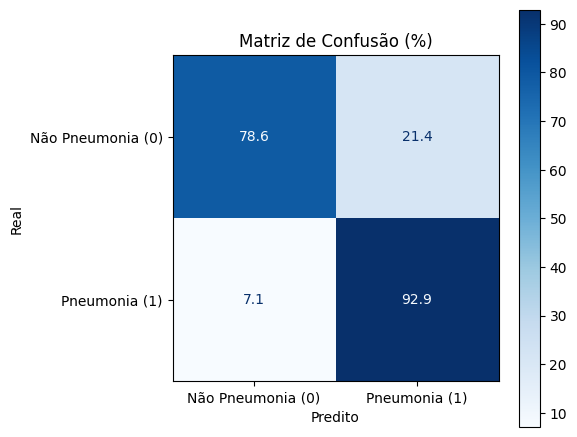


Análise da Matriz de Confusão em %:
Cada célula mostra a **porcentagem** de amostras da classe real (linha) que foi predita como a classe correspondente (coluna).
A soma das porcentagens em cada linha (horizontalmente) deve ser **100%**.


In [ ]:
"""
- MATRIZES DE CONFUSÃO:

Realiza previsões no conjunto de teste e então calcula e exibe
mapas de calor das matrizes de confusão.
"""

# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_resnet50_balanced_unfreeze5.keras'

# Carregar o modelo salvo
model = tf.keras.models.load_model(saved_model_path)
print(f"Modelo carregado com sucesso de: {saved_model_path}")

print("Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...")

# Re-cria o dataset de teste SEM shuffle para garantir a ordem das previsões
test_images_paths = balanced_test_df['image_path'].values
test_true_binary_labels = balanced_test_df['Target'].values.astype(np.float32)
test_true_detailed_labels = balanced_test_df['detailed_class'].values

temp_test_dataset_for_prediction = tf.data.Dataset.from_tensor_slices((test_images_paths, test_true_binary_labels))
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(apply_transformations, num_parallel_calls=buffer_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.batch(batch_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.prefetch(buffer_size=buffer_size)

# Obter as probabilidades de predição do modelo
y_pred_probs = model.predict(temp_test_dataset_for_prediction).flatten()

# Converter probabilidades para classes binárias (0 ou 1)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Preparar Labels para a Matriz de Confusão
true_labels_for_cm = test_true_detailed_labels
predicted_labels_for_cm = np.array(['Não Pneumonia (0)' if p == 0 else 'Pneumonia (1)' for p in y_pred_binary])

true_class_order = ['Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity']
predicted_class_order = ['Não Pneumonia (0)', 'Pneumonia (1)']

# Gerar Matriz de Confusão
cm_bin_abs = confusion_matrix(test_true_binary_labels, y_pred_binary, labels=[0,1])

# Normalizar a matriz de confusão por linha
cm_bin_percent = cm_bin_abs.astype('float') / cm_bin_abs.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin_percent,
                              display_labels=['Não Pneumonia (0)', 'Pneumonia (1)'])
fig, ax = plt.subplots(figsize=(6,5))

disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".1f")
ax.set_title('Matriz de Confusão (%)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

## Modelo Resnet50 com Balanceamento e Descongelamento das 10 Camadas: 

In [ ]:
"""
- DEFINIÇÃO DO MODELO RESNET50 PARA CLASSIFICAÇÃO BINÁRIA
"""

# Definição do Modelo Keras
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congela as camadas do modelo base
base_model.trainable = False

# Cria o modelo sequencial no topo do modelo base
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

print("Modelo Keras definido.")
model.summary()



Modelo Keras definido.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
"""
- DESCONGELAMENTO E COMPILAÇÃO DO MODELO PARA FINE-TUNING:

Descongela as últimas 10 camadas convolucionais e de Batch Normalization da base do modelo.
Em seguida, o modelo é recompilado com uma taxa de aprendizado mais baixa
para permitir o treinamento dessas camadas.
"""

print("\n--- Etapa de Fine-tuning: Descongelando as últimas 10 camadas convolucionais ---")

# Descongela a base do modelo
base_model.trainable = True

# Descongela as últimas 10 camadas convolucionais e de Batch Normalization
num_layers_to_unfreeze = 10
unfrozen_count = 0
for layer in reversed(base_model.layers):
    if unfrozen_count < num_layers_to_unfreeze:
        if isinstance(layer, (layers.Conv2D, layers.BatchNormalization)):
            layer.trainable = True
            unfrozen_count += 1
            print(f"Descongelando camada: {layer.name}")
        else:
            layer.trainable = True
    else:
        layer.trainable = False

# Recompila o modelo para aplicar as mudanças
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nModelo após descongelar as últimas 10 camadas convolucionais:")
model.summary(expand_nested=True)


--- Etapa de Fine-tuning: Descongelando as últimas 10 camadas convolucionais ---
Descongelando camada: conv5_block3_3_bn
Descongelando camada: conv5_block3_3_conv
Descongelando camada: conv5_block3_2_bn
Descongelando camada: conv5_block3_2_conv
Descongelando camada: conv5_block3_1_bn
Descongelando camada: conv5_block3_1_conv
Descongelando camada: conv5_block2_3_bn
Descongelando camada: conv5_block2_3_conv
Descongelando camada: conv5_block2_2_bn
Descongelando camada: conv5_block2_2_conv

Modelo após descongelar as últimas 10 camadas convolucionais:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 256, 256, 3)]     0        |
|                                                               |
| conv1_pad (ZeroPadding2D)  

| conv1_relu (Activation)    (None, 128, 128, 64)      0        |
|                                                               |
| pool1_pad (ZeroPadding2D)  (None, 130, 130, 64)      0        |
|                                                               |
| pool1_pool (MaxPooling2D)  (None, 64, 64, 64)        0        |
|                                                               |
| conv2_block1_1_conv (Conv  (None, 64, 64, 64)        4160     |
| 2D)                                                           |
|                                                               |
| conv2_block1_1_bn (BatchN  (None, 64, 64, 64)        256      |
| ormalization)                                                 |
|                                                               |
| conv2_block1_1_relu (Acti  (None, 64, 64, 64)        0        |
| vation)                                                       |
|                                                               |
| conv2_bl

In [ ]:
"""
- COMPILAÇÃO DO MODELO
"""

# Compilação do Modelo
optimizer = Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics = [BinaryAccuracy(name='accuracy'), AUC(name='auc')]

# Compila o modelo
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

print("Modelo compilado.")

Modelo compilado.


In [ ]:
"""
- TREINAMENTO DO MODELO:

Define ModelCheckpoint para salvar o melhor modelo durante o treinamento e, em seguida,
inicia o treinamento.
"""

# Callbacks de Treinamento
checkpoint_callback = ModelCheckpoint(
    filepath='best_pneumonia_resnet50_balanced_unfreeze10.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [checkpoint_callback]

# Treinamento do Modelo
epochs = 5

print("Iniciando treinamento...")

history = model.fit(
    balanced_train_dataset,
    epochs=epochs,
    validation_data=balanced_val_dataset,
    callbacks=callbacks_list
)

print("Treinamento concluído.")

Iniciando treinamento...
Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7843 - auc: 0.8491 - loss: 0.4985
Epoch 1: val_auc improved from -inf to 0.84646, saving model to best_pneumonia_resnet50_balanced_unfreeze10.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 885s 3s/step - accuracy: 0.7845 - auc: 0.8493 - loss: 0.4982 - val_accuracy: 0.5793 - val_auc: 0.8465 - val_loss: 1.5611
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8691 - auc: 0.9350 - loss: 0.3221
Epoch 2: val_auc improved from 0.84646 to 0.92959, saving model to best_pneumonia_resnet50_balanced_unfreeze10.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 893s 3s/step - accuracy: 0.8691 - auc: 0.9350 - loss: 0.3221 - val_accuracy: 0.8392 - val_auc: 0.9296 - val_loss: 0.3837
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8834 - auc: 0.9473 - loss: 0.2874
Epoch 3: val_auc did not improve from 0.92959
263/263 ━━━━━━━━━━━━━━━━━━━━ 908s 3s/step - accuracy: 0.8834 - auc: 0.9473 - loss: 0.2874 - val_accuracy

In [ ]:
"""
- AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE
"""

# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_resnet50_balanced_unfreeze10.keras'

# Carregar o modelo salvo
try:
    model = tf.keras.models.load_model(saved_model_path)
    print(f"Modelo carregado com sucesso de: {saved_model_path}")

    if 'test_dataset' in locals():
        print("Avaliando o modelo carregado no conjunto de teste...")
        model.evaluate(balanced_test_dataset)
    else:
        print("test_dataset não encontrado. Não é possível avaliar o modelo carregado.")

except Exception as e:
    print(f"Erro ao carregar o modelo de {saved_model_path}: {e}")
    print("Certifique-se de que o caminho está correto e o arquivo existe.")

Modelo carregado com sucesso de: best_pneumonia_resnet50_balanced_unfreeze10.keras
Avaliando o modelo carregado no conjunto de teste...
57/57 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8651 - auc: 0.9499 - loss: 0.3300


Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...
57/57 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step


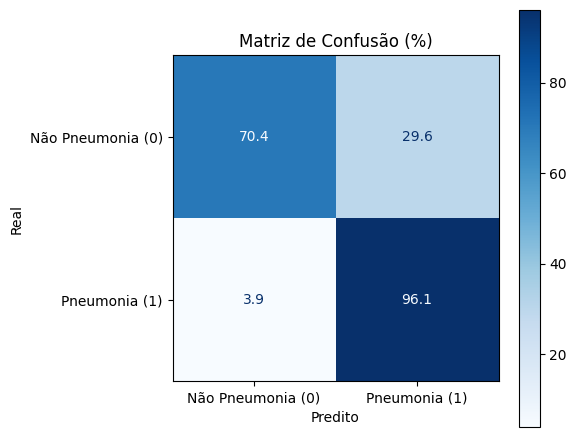


Análise da Matriz de Confusão em %:
Cada célula mostra a **porcentagem** de amostras da classe real (linha) que foi predita como a classe correspondente (coluna).
A soma das porcentagens em cada linha (horizontalmente) deve ser **100%**.


In [ ]:
"""
- MATRIZES DE CONFUSÃO:

Realiza previsões no conjunto de teste e então calcula e exibe
mapas de calor das matrizes de confusão.
"""

# Caminho para o seu modelo salvo
saved_model_path = 'best_pneumonia_resnet50_balanced_unfreeze10.keras'

# Carregar o modelo salvo
model = tf.keras.models.load_model(saved_model_path)
print(f"Modelo carregado com sucesso de: {saved_model_path}")

print("Iniciando a avaliação para a matriz de confusão: Classes Reais Detalhadas vs. Predição Binária (em %)...")

# Re-cria o dataset de teste SEM shuffle para garantir a ordem das previsões
test_images_paths = balanced_test_df['image_path'].values
test_true_binary_labels = balanced_test_df['Target'].values.astype(np.float32)
test_true_detailed_labels = balanced_test_df['detailed_class'].values

temp_test_dataset_for_prediction = tf.data.Dataset.from_tensor_slices((test_images_paths, test_true_binary_labels))
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(tf_load_and_preprocess, num_parallel_calls=buffer_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.map(apply_transformations, num_parallel_calls=buffer_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.batch(batch_size)
temp_test_dataset_for_prediction = temp_test_dataset_for_prediction.prefetch(buffer_size=buffer_size)

# Obter as probabilidades de predição do modelo
y_pred_probs = model.predict(temp_test_dataset_for_prediction).flatten()

# Converter probabilidades para classes binárias (0 ou 1)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Preparar Labels para a Matriz de Confusão
true_labels_for_cm = test_true_detailed_labels
predicted_labels_for_cm = np.array(['Não Pneumonia (0)' if p == 0 else 'Pneumonia (1)' for p in y_pred_binary])

true_class_order = ['Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity']
predicted_class_order = ['Não Pneumonia (0)', 'Pneumonia (1)']

# Gerar Matriz de Confusão
cm_bin_abs = confusion_matrix(test_true_binary_labels, y_pred_binary, labels=[0,1])

# Normalizar a matriz de confusão por linha
cm_bin_percent = cm_bin_abs.astype('float') / cm_bin_abs.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin_percent,
                              display_labels=['Não Pneumonia (0)', 'Pneumonia (1)'])
fig, ax = plt.subplots(figsize=(6,5))

disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".1f")
ax.set_title('Matriz de Confusão (%)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [ ]:
"""
- GERAÇÃO E VISUALIZAÇÃO DE GRAD-CAM:

Define funções para carregar e pré-processar imagens DICOM, gerar heatmaps Grad-CAM,
e sobrepor esses heatmaps às imagens originais. O bloco principal carrega um modelo,
seleciona uma imagem de teste, aplica o Grad-CAM e exibe as visualizações
resultantes, incluindo bounding boxes reais, se aplicável.
"""

IMG_SIZE = 256

def load_and_preprocess_image_for_gradcam_tf(image_path_str):
    # Carrega imagem DICOM, pré-processa para o modelo TensorFlow e para visualização.
    dcm_data = pydicom.dcmread(image_path_str)
    image = dcm_data.pixel_array
    original_dicom_shape = image.shape[:2]

    image_float = image.astype(np.float32)
    img_min_val = np.min(image_float)
    img_max_val = np.max(image_float)

    if img_max_val - img_min_val > 0:
        image_scaled_0_1 = (image_float - img_min_val) / (img_max_val - img_min_val)
    else:
        image_scaled_0_1 = np.zeros_like(image_float)

    image_scaled_0_255 = (image_scaled_0_1 * 255.0).astype(np.float32)

    if image_scaled_0_255.ndim == 2:
        image_rgb_0_255 = np.stack([image_scaled_0_255] * 3, axis=-1)
    elif image_scaled_0_255.ndim == 3 and image_scaled_0_255.shape[-1] == 1:
        image_rgb_0_255 = np.concatenate([image_scaled_0_255] * 3, axis=-1)
    elif image_scaled_0_255.ndim == 3 and image_scaled_0_255.shape[-1] == 3:
        image_rgb_0_255 = image_scaled_0_255
    else:
        raise ValueError(f"Formato de imagem DICOM não suportado para conversão para RGB: {image_scaled_0_255.shape}")

    image_resized_0_255 = tf.image.resize(image_rgb_0_255, (IMG_SIZE, IMG_SIZE)).numpy()

    img_for_visualization_resized = image_resized_0_255.astype(np.uint8)

    img_array_for_preprocess = np.expand_dims(image_resized_0_255.astype("float32"), axis=0)
    img_array_processed = tf.keras.applications.resnet50.preprocess_input(img_array_for_preprocess)

    return img_array_processed, img_for_visualization_resized, original_dicom_shape

def make_gradcam_heatmap_tf(img_array_preprocessed, grad_model_instance, pred_index=None):
    # Gera o heatmap Grad-CAM.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model_instance(img_array_preprocessed)
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output_no_batch = last_conv_layer_output[0]

    heatmap = last_conv_layer_output_no_batch * pooled_grads
    heatmap = tf.reduce_sum(heatmap, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap)
    if max_val == 0:
        heatmap = tf.zeros_like(heatmap)
    else:
        heatmap = heatmap / max_val

    return heatmap.numpy()

def superimpose_gradcam_tf(original_img_rgb_resized, heatmap, alpha=0.4):
    # Sobrepõe o heatmap à imagem RGB original redimensionada.
    heatmap_resized_cv = cv2.resize(heatmap, (original_img_rgb_resized.shape[1], original_img_rgb_resized.shape[0]))
    heatmap_colored_cv = cv2.applyColorMap(np.uint8(255 * heatmap_resized_cv), cv2.COLORMAP_JET)
    heatmap_colored_rgb = cv2.cvtColor(heatmap_colored_cv, cv2.COLOR_BGR2RGB)

    original_img_float = original_img_rgb_resized.astype(np.float32)
    heatmap_colored_float = heatmap_colored_rgb.astype(np.float32)

    superimposed_img = cv2.addWeighted(original_img_float, 1 - alpha, heatmap_colored_float, alpha, 0)
    return np.uint8(superimposed_img)

# Bloco Principal para Grad-CAM
keras_model_path = 'best_pneumonia_resnet50_balanced_unfreeze10.keras'

if 'test_df' in locals() and not test_df.empty:
    test_df_for_gradcam = test_df
    print("Usando 'test_df' (do notebook original TensorFlow) para Grad-CAM.")
else:
    print("ERRO: DataFrame de teste ('test_df_final' ou 'test_df') não encontrado ou vazio.")
    test_df_for_gradcam = None

if test_df_for_gradcam is not None and not test_df_for_gradcam.empty:
    try:
        model_keras = tf.keras.models.load_model(keras_model_path, compile=False)
        print(f"Modelo Keras '{keras_model_path}' carregado com sucesso.")

        base_resnet_layer_name = "resnet50"
        target_conv_in_resnet_name = "conv5_block3_out"

        resnet_base_as_model_layer = model_keras.get_layer(base_resnet_layer_name)
        target_conv_actual_layer = resnet_base_as_model_layer.get_layer(target_conv_in_resnet_name)

        grad_model_for_cam = tf.keras.models.Model(
            inputs=model_keras.inputs,
            outputs=[target_conv_actual_layer.output, model_keras.output]
        )
        print("Grad-CAM model (funcional) construído.")

        sample_idx_keras = np.random.randint(0, len(test_df_for_gradcam))
        sample_data_keras = test_df_for_gradcam.iloc[sample_idx_keras]

        image_path_keras = sample_data_keras['image_path']
        true_label_keras = sample_data_keras['Target']
        detailed_class_true_keras = sample_data_keras['detailed_class']
        true_boxes_keras = sample_data_keras['boxes']

        print(f"\nGerando Grad-CAM para a imagem: {os.path.basename(image_path_keras)}")
        print(f"Target Real: {true_label_keras} ({detailed_class_true_keras})")
        if true_label_keras == 1 and true_boxes_keras and isinstance(true_boxes_keras, list) and len(true_boxes_keras) > 0:
            print(f"Bounding Boxes Originais: {true_boxes_keras}")

        img_array_preprocessed_for_model, img_for_viz_resized_rgb, orig_dicom_shape = load_and_preprocess_image_for_gradcam_tf(image_path_keras)

        heatmap = make_gradcam_heatmap_tf(img_array_preprocessed_for_model, grad_model_for_cam)

        preds_keras = model_keras.predict(img_array_preprocessed_for_model)
        predicted_prob_keras = preds_keras[0][0]
        predicted_class_keras = 1 if predicted_prob_keras > 0.5 else 0
        print(f"Modelo Keras predisse: Classe {predicted_class_keras} (Probabilidade para classe 1: {predicted_prob_keras:.4f})")

        # Visualização
        superimposed_display = superimpose_gradcam_tf(img_for_viz_resized_rgb, heatmap, alpha=0.5)

        fig, axs = plt.subplots(1, 4, figsize=(24, 6))

        axs[0].imshow(img_for_viz_resized_rgb)
        axs[0].set_title(f"Original Redimensionada (Real: {true_label_keras})")
        axs[0].axis('off')

        axs[1].imshow(cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE)), cmap='jet')
        axs[1].set_title("Heatmap Grad-CAM Puro")
        axs[1].axis('off')

        axs[2].imshow(superimposed_display)
        axs[2].set_title(f"Grad-CAM Overlay (Pred: {predicted_class_keras})")
        axs[2].axis('off')

        img_overlay_with_boxes_keras = superimposed_display.copy()
        title_bbox_keras = f"Grad-CAM Overlay (Pred: {predicted_class_keras})"

        if true_label_keras == 1 and true_boxes_keras and isinstance(true_boxes_keras, list) and len(true_boxes_keras) > 0:
            scale_x = IMG_SIZE / orig_dicom_shape[1]
            scale_y = IMG_SIZE / orig_dicom_shape[0]

            pil_img_for_drawing = Image.fromarray(img_overlay_with_boxes_keras)
            draw = ImageDraw.Draw(pil_img_for_drawing)
            box_drawn_count = 0
            for box in true_boxes_keras:
                if not (isinstance(box, list) and len(box) == 4 and all(isinstance(coord, (int, float, np.number)) for coord in box)):
                    continue
                x_min, y_min, x_max, y_max = box
                x1_s, y1_s = int(x_min * scale_x), int(y_min * scale_y)
                x2_s, y2_s = int(x_max * scale_x), int(y_max * scale_y)
                draw.rectangle([(x1_s, y1_s), (x2_s, y2_s)], outline="lime", width=3)
                box_drawn_count +=1

            if box_drawn_count > 0:
                img_overlay_with_boxes_keras = np.array(pil_img_for_drawing)
                title_bbox_keras = "Grad-CAM + BBoxes Reais"

        axs[3].imshow(img_overlay_with_boxes_keras)
        axs[3].set_title(title_bbox_keras)
        axs[3].axis('off')

        plt.suptitle(f"Grad-CAM (TensorFlow/Keras) para {os.path.basename(image_path_keras)}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    except FileNotFoundError:
        print(f"ERRO: Arquivo do modelo não encontrado em '{keras_model_path}'. Verifique o caminho.")
    except ValueError as ve:
        print(f"ERRO de Valor (provavelmente nome de camada incorreto): {ve}")
        if 'model_keras' in locals():
            print("Sumário do modelo carregado:")
            model_keras.summary()
            if 'resnet_base_as_model_layer' in locals() and resnet_base_as_model_layer is not None:
                print("\nSumário da camada base ResNet ('resnet50'):")
                resnet_base_as_model_layer.summary()
        import traceback
        traceback.print_exc()
    except Exception as e:
        print(f"Ocorreu um erro geral ao carregar o modelo Keras ou gerar Grad-CAM: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Não foi possível executar o Grad-CAM pois o DataFrame de teste ('test_df_for_gradcam') não está disponível ou está vazio.")

Usando 'test_df' (do notebook original TensorFlow) para Grad-CAM.
Modelo Keras 'best_pneumonia_resnet50_balanced_unfreeze10.keras' carregado com sucesso.
Ocorreu um erro geral ao carregar o modelo Keras ou gerar Grad-CAM: The layer sequential_2 has never been called and thus has no defined output.


Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Temp\ipykernel_44380\4074445438.py", line 159, in <module>
    outputs=[target_conv_actual_layer.output, model_keras.output]
                                              ^^^^^^^^^^^^^^^^^^
  File "c:\Users\gabri\Downloads\RSNA-PneumoniaDetection\venv_RSNA\Lib\site-packages\keras\src\ops\operation.py", line 288, in output
    return self._get_node_attribute_at_index(0, "output_tensors", "output")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gabri\Downloads\RSNA-PneumoniaDetection\venv_RSNA\Lib\site-packages\keras\src\ops\operation.py", line 307, in _get_node_attribute_at_index
    raise AttributeError(
AttributeError: The layer sequential_2 has never been called and thus has no defined output.


## Usando as 3 Classes - Modelo Resnet50 com Balanceamento e Descongelamento das 10 Camadas: 

Configuração inicial e imports concluídos.
Dados carregados e DataFrame de imagens criado.
Número de imagens no DataFrame: 26684
Distribuição da classe Target:
Target
0    20672
1     6012
Name: count, dtype: int64
Distribuição da detailed_class (novo target):
detailed_class
No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: count, dtype: int64

Classes detalhadas mapeadas para números: [(0, np.str_('Lung Opacity')), (1, np.str_('No Lung Opacity / Not Normal')), (2, np.str_('Normal'))]
Número de classes: 3

Aplicando balanceamento ao DataFrame de Treino (Multi-classe)...

Balanceamento concluído para uma divisão. Estatísticas para este DataFrame balanceado (Multi-classe):
  Total de amostras: 12624
  Distribuição da classe detalhada codificada:
encoded_detailed_class
1    4208
2    4208
0    4208
Name: count, dtype: int64
  Distribuição da classe detalhada (original):
detailed_class
No Lung Opacity / Not Normal    420

Model: "PneumoniaClassifier_PartialUnfrozen_Multiclass"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense (Dense)        │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 7,887,363 (30.09 MB)

 Non-trainable params: 15,706,496 (59.92 MB)

Modelo compilado para multi-classificação.
Iniciando treinamento (multi-class, 10 últimas camadas descongeladas)...
Epoch 1/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5170 - auc: 0.6990 - loss: 0.9740
Epoch 1: val_auc improved from -inf to 0.77784, saving model to best_pneumonia_resnet50_balanced_unfreeze10_multiclass.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 1554s 4s/step - accuracy: 0.5171 - auc: 0.6991 - loss: 0.9738 - val_accuracy: 0.5883 - val_auc: 0.7778 - val_loss: 0.8660
Epoch 2/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6292 - auc: 0.8070 - loss: 0.8066
Epoch 2: val_auc improved from 0.77784 to 0.79098, saving model to best_pneumonia_resnet50_balanced_unfreeze10_multiclass.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 1657s 4s/step - accuracy: 0.6293 - auc: 0.8070 - loss: 0.8065 - val_accuracy: 0.6160 - val_auc: 0.7910 - val_loss: 0.8202
Epoch 3/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6604 - auc: 0.8390 - loss: 0.7404
Epoch 3: val_auc improved from 0.79

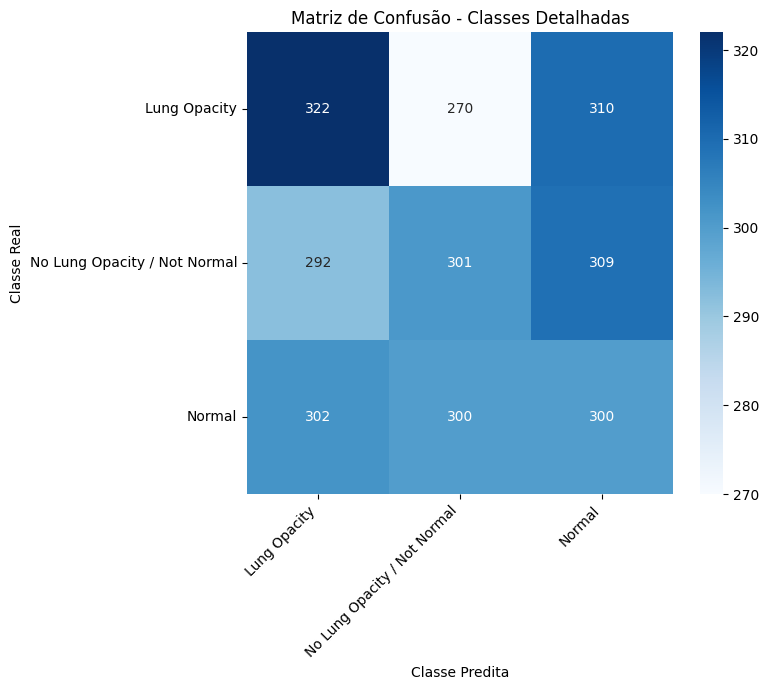


--- Matriz de Confusão Normalizada (Classes Detalhadas Reais vs. Preditas em %) ---
                              Lung Opacity  No Lung Opacity / Not Normal  \
Lung Opacity                     35.698448                     29.933481   
No Lung Opacity / Not Normal     32.372506                     33.370288   
Normal                           33.481153                     33.259424   

                                 Normal  
Lung Opacity                  34.368071  
No Lung Opacity / Not Normal  34.257206  
Normal                        33.259424  


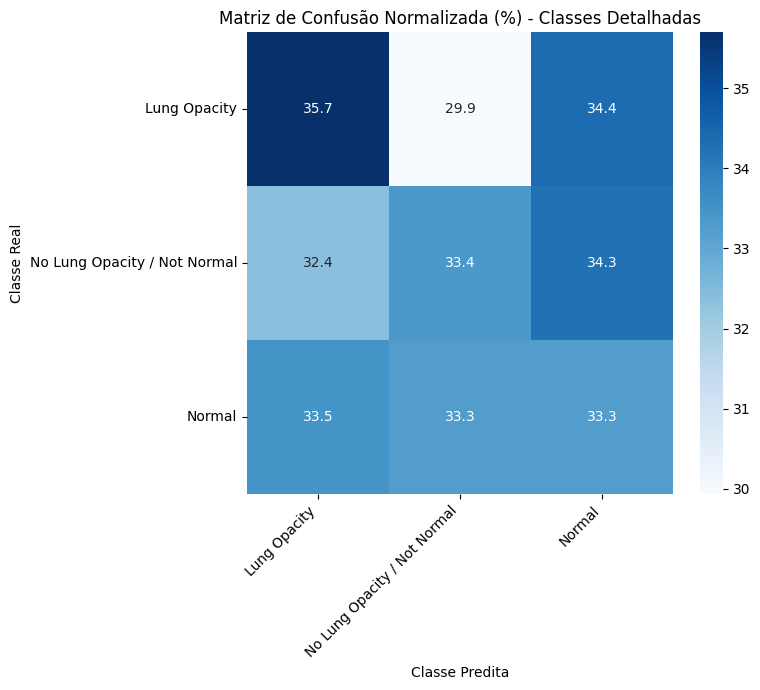

In [ ]:
"""
- PREPARAÇÃO DE DADOS, MODELO E PIPELINE PARA CLASSIFICAÇÃO MULTI-CLASSE
"""

print("Configuração inicial e imports concluídos.")

# Carregar Dados e Preparar Detailed Classes
image_base_dir = 'rsna-pneumonia-detection-challenge/stage_2_train_images'
annotation_file_path = 'rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
detailed_info_path = 'rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'

annotations_df = pd.read_csv(annotation_file_path)
detailed_info_df = pd.read_csv(detailed_info_path)

dcm_files = glob.glob(os.path.join(image_base_dir, '*.dcm'))
patient_id_to_path = {os.path.splitext(os.path.basename(dcm_path))[0]: dcm_path for dcm_path in dcm_files}

# Criar o dicionário PatientID para Informação Detalhada da Classe
patient_id_to_detailed_class = detailed_info_df.set_index('patientId')['class'].to_dict()

data_for_df = []
available_patient_ids = list(patient_id_to_path.keys())

for patient_id in available_patient_ids:
    patient_annotations = annotations_df[annotations_df['patientId'] == patient_id].to_dict('records')
    image_path = patient_id_to_path.get(patient_id)
    detailed_class = patient_id_to_detailed_class.get(patient_id, 'Unknown')

    if not patient_annotations:
        image_target = 0 if 'Normal' in detailed_class else 1
    else:
        image_target = patient_annotations[0]['Target']

    boxes = []
    if image_target == 1:
        for ann in patient_annotations:
            if not pd.isna(ann['x']) and ann['Target'] == 1:
                x, y, w, h = ann['x'], ann['y'], ann['width'], ann['height']
                boxes.append([x, y, x + w, y + h])

    if image_path:
        data_for_df.append({
            'patientId': patient_id,
            'image_path': image_path,
            'Target': image_target,
            'detailed_class': detailed_class,
            'boxes': boxes,
            'num_boxes': len(boxes)
        })

images_with_boxes_df = pd.DataFrame(data_for_df)

print("Dados carregados e DataFrame de imagens criado.")
print(f"Número de imagens no DataFrame: {len(images_with_boxes_df)}")
print(f"Distribuição da classe Target:\n{images_with_boxes_df['Target'].value_counts()}")
print(f"Distribuição da detailed_class (novo target):\n{images_with_boxes_df['detailed_class'].value_counts()}")

# Codifica detailed_class para rótulos numéricos e One-Hot Encoding
label_encoder = LabelEncoder()
fixed_classes_order = ['Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity']
label_encoder.fit(fixed_classes_order)

ordered_detailed_classes = label_encoder.classes_
NUM_CLASSES = len(ordered_detailed_classes)

images_with_boxes_df['encoded_detailed_class'] = label_encoder.transform(images_with_boxes_df['detailed_class'])
one_hot_encoder = OneHotEncoder(sparse_output=False, categories=[ordered_detailed_classes])
images_with_boxes_df['one_hot_labels'] = list(one_hot_encoder.fit_transform(images_with_boxes_df[['detailed_class']]))

print(f"\nClasses detalhadas mapeadas para números: {list(enumerate(ordered_detailed_classes))}")
print(f"Número de classes: {NUM_CLASSES}")

# Função para carregar e pré-processar uma única imagem DICOM (para tf.py_function)
IMG_SIZE = 256

def load_and_preprocess_image_tf_pyfunc(image_path, label):
    # Carrega imagem DICOM e pré-processa.
    image_path_str = image_path.numpy().decode('utf-8')
    dcm_data = pydicom.dcmread(image_path_str)
    image = dcm_data.pixel_array

    image = image.astype(np.float32)
    min_val = image.min()
    max_val = image.max()
    if max_val - min_val > 0:
        image = (image - min_val) / (max_val - min_val) * 255.0
    else:
        image = np.zeros_like(image, dtype=np.float32)

    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.ndim == 3 and image.shape[-1] == 1:
        image = np.concatenate([image] * 3, axis=-1)

    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
    return image_tensor, label_tensor

# Função Wrapper para tf.py_function
def tf_load_and_preprocess_wrapper(image_path, label):
    # Wrapper para chamar load_and_preprocess_image_tf_pyfunc com tf.py_function.
    image, label = tf.py_function(
        load_and_preprocess_image_tf_pyfunc,
        [image_path, label],
        [tf.float32, tf.float32]
    )
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    label.set_shape((NUM_CLASSES,))
    return image, label

# Definição das Transformações de Imagem com TensorFlow Ops
def apply_transformations(image, label):
    # Aplica redimensionamento e normalização usando TensorFlow Ops.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    image = (image - mean) / std
    return image, label

# Divisão dos Dados
train_df, temp_df = train_test_split(images_with_boxes_df, test_size=0.3, random_state=42, stratify=images_with_boxes_df['detailed_class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['detailed_class'])

# Função de Balanceamento de Dados (Adaptada para Multi-classes)
def balance_dataframe_multiclass(df_to_balance, target_class_counts=None, random_seed=42):
    # Balanceia um DataFrame com base nas classes detalhadas codificadas.
    np.random.seed(random_seed)

    balanced_dfs = []
    if target_class_counts is None:
        min_class_size = df_to_balance['encoded_detailed_class'].value_counts().min()
        target_class_counts = {cls_label: min_class_size for cls_label in df_to_balance['encoded_detailed_class'].unique()}

    for class_label in sorted(df_to_balance['encoded_detailed_class'].unique()):
        class_df = df_to_balance[df_to_balance['encoded_detailed_class'] == class_label]
        num_samples_target = target_class_counts.get(class_label, len(class_df))

        if len(class_df) < num_samples_target:
            sampled_class_df = class_df.sample(n=num_samples_target, replace=True, random_state=random_seed)
        else:
            sampled_class_df = class_df.sample(n=num_samples_target, replace=False, random_state=random_seed)
        balanced_dfs.append(sampled_class_df)

    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=random_seed).reset_index(drop=True)

    print(f"\nBalanceamento concluído para uma divisão. Estatísticas para este DataFrame balanceado (Multi-classe):")
    print(f"  Total de amostras: {len(balanced_df)}")
    print(f"  Distribuição da classe detalhada codificada:\n{balanced_df['encoded_detailed_class'].value_counts()}")
    print(f"  Distribuição da classe detalhada (original):\n{balanced_df['detailed_class'].value_counts()}")
    return balanced_df

print("\nAplicando balanceamento ao DataFrame de Treino (Multi-classe)...")
balanced_train_df = balance_dataframe_multiclass(train_df, random_seed=42)

print("\nAplicando balanceamento ao DataFrame de Validação (Multi-classe)...")
balanced_val_df = balance_dataframe_multiclass(val_df, random_seed=42)

print("\nAplicando balanceamento ao DataFrame de Teste (Multi-classe)...")
balanced_test_df = balance_dataframe_multiclass(test_df, random_seed=42)

# Criação dos TensorFlow Datasets com Rótulos One-Hot Encoded
batch_size = 32
buffer_size = tf.data.AUTOTUNE

def create_tf_dataset_pipeline_multiclass(df, buffer_size, batch_size):
    # Cria e pré-processa um TensorFlow Dataset para multi-classe.
    paths = df['image_path'].values
    labels_one_hot = np.array(df['one_hot_labels'].tolist(), dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels_one_hot))
    dataset = dataset.map(tf_load_and_preprocess_wrapper, num_parallel_calls=buffer_size)
    dataset = dataset.map(apply_transformations, num_parallel_calls=buffer_size)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=buffer_size)
    return dataset

print("\nRecriando Datasets TensorFlow com dados multi-classe balanceados...")
balanced_train_dataset = create_tf_dataset_pipeline_multiclass(balanced_train_df, buffer_size, batch_size)
balanced_val_dataset = create_tf_dataset_pipeline_multiclass(balanced_val_df, buffer_size, batch_size)
balanced_test_dataset = create_tf_dataset_pipeline_multiclass(balanced_test_df, buffer_size, batch_size)
print("Datasets TensorFlow balanceados (treino, validação, teste) criados com sucesso para multi-classe.")

# Definição do Modelo Keras (Com as ÚLTIMAS 10 Camadas Descongeladas para Fine-tuning)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congela TODAS as camadas da base_model primeiro
base_model.trainable = False

# Descongela as últimas 10 camadas treináveis (Conv2D ou BatchNormalization)
num_layers_to_unfreeze = 10
unfrozen_count = 0
for layer in reversed(base_model.layers):
    if unfrozen_count < num_layers_to_unfreeze:
        if isinstance(layer, (layers.Conv2D, layers.BatchNormalization)):
            layer.trainable = True
            unfrozen_count += 1
            print(f"Descongelando camada: {layer.name}")
        else:
            pass
    else:
        layer.trainable = False

# Cria o modelo sequencial no topo do modelo base
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(name="global_avg_pool"),
    layers.Dense(NUM_CLASSES, activation='softmax', name="classifier_dense")
], name="PneumoniaClassifier_PartialUnfrozen_Multiclass")

print("Modelo Keras definido para multi-classificação (10 últimas camadas descongeladas).")
model.summary()

# Compilação do Modelo
optimizer = Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metrics = [
    CategoricalAccuracy(name='accuracy'),
    AUC(name='auc', multi_label=True)
]

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
print("Modelo compilado para multi-classificação.")

# Callbacks de Treinamento
checkpoint_callback = ModelCheckpoint(
    filepath='best_pneumonia_resnet50_balanced_unfreeze10_multiclass.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
callbacks_list = [checkpoint_callback]

# Treinamento do Modelo
epochs = 5
print("Iniciando treinamento (multi-class, 10 últimas camadas descongeladas)...")
history = model.fit(
    balanced_train_dataset,
    epochs=epochs,
    validation_data=balanced_val_dataset,
    callbacks=callbacks_list
)
print("Treinamento (multi-class) concluído.")

# Avaliação e Matriz de Confusão para Multi-classe
saved_model_path = 'best_pneumonia_resnet50_balanced_unfreeze10_multiclass.keras'

try:
    model_loaded = tf.keras.models.load_model(saved_model_path)
    print(f"\nModelo carregado com sucesso de: {saved_model_path}")

    print("Avaliando o modelo carregado no conjunto de teste...")
    model_loaded.evaluate(balanced_test_dataset)

    print("\nCalculando previsões para a matriz de confusão (multi-classe)...")
    y_pred_probs_multiclass = model_loaded.predict(balanced_test_dataset)
    y_pred_multiclass_labels = np.argmax(y_pred_probs_multiclass, axis=1)

    y_true_multiclass_encoded = balanced_test_df['encoded_detailed_class'].values

    # Matriz de Confusão
    print("\n--- Matriz de Confusão (Classes Detalhadas Reais vs. Preditas) ---")

    cm_multiclass = confusion_matrix(
        y_true_multiclass_encoded,
        y_pred_multiclass_labels,
        labels=np.arange(NUM_CLASSES)
    )

    cm_df_multiclass = pd.DataFrame(cm_multiclass, index=ordered_detailed_classes, columns=ordered_detailed_classes)
    print(cm_df_multiclass)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm_df_multiclass, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão - Classes Detalhadas')
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Real')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Matriz de Confusão Normalizada (em porcentagens)
    print("\n--- Matriz de Confusão Normalizada (Classes Detalhadas Reais vs. Preditas em %) ---")
    cm_normalized_multiclass = cm_multiclass.astype('float') / cm_multiclass.sum(axis=1)[:, np.newaxis] * 100
    cm_df_normalized_multiclass = pd.DataFrame(cm_normalized_multiclass, index=ordered_detailed_classes, columns=ordered_detailed_classes)
    print(cm_df_normalized_multiclass)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm_df_normalized_multiclass, annot=True, fmt='.1f', cmap='Blues')
    plt.title('Matriz de Confusão Normalizada (%) - Classes Detalhadas')
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Real')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Erro ao carregar o modelo ou executar avaliação/Grad-CAM: {e}")
    import traceback
    traceback.print_exc()